# Model 3 - TimeFormer, transformers applied to time series forecasting

This notebook builds step by step a model based on the transformer architecture to solve the problem of time series forecasting.  

## Imports and Data pre-processing

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
np.random.seed(0)

In [3]:
from google.colab import drive
WEATHER_DATA_PATH = "/content/gdrive/MyDrive/Machine Learning/Datasets/weather_forecasting"
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [112]:
path = '/home/rbazin/ECSE552/ECSE552-HW4/'

In [113]:
def custom_date_parser(date_string):
    return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

In [114]:
data = pd.read_csv(os.path.join(path, "weather_train.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
data.head()

/tmp/ipykernel_1220524/649081062.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [115]:
data.sort_values(by='Date Time', ascending=True, inplace=True)

In [116]:
data = data.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

Let's visualize the evolution of the four labels to predict over time :

<Axes: xlabel='date'>

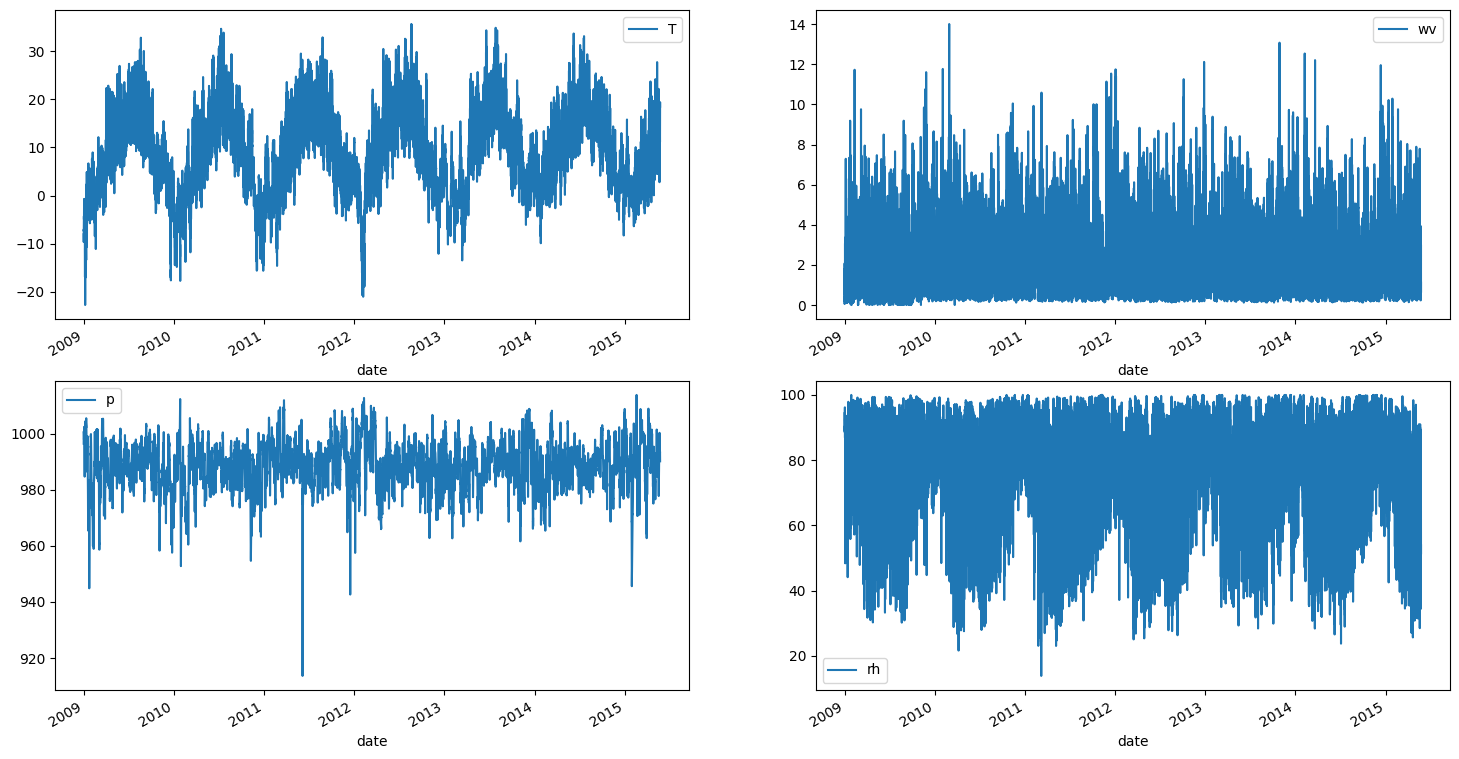

In [117]:
# create a subplot with 4 rows and 1 column
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# plot the graphs for each label
data.plot(ax=ax[0][0], x='date', y='T')
data.plot(ax=ax[1][0], x='date', y='p')
data.plot(ax=ax[1][1], x='date', y='rh')
data.plot(ax=ax[0][1], x='date', y='wv')

We can already see that three of the four labels are pretty close to being periodic, the last label "wind velocity" (wv) may represent a challenge for our model.

In the meantime, let's observe the distribution of the values of our labels :

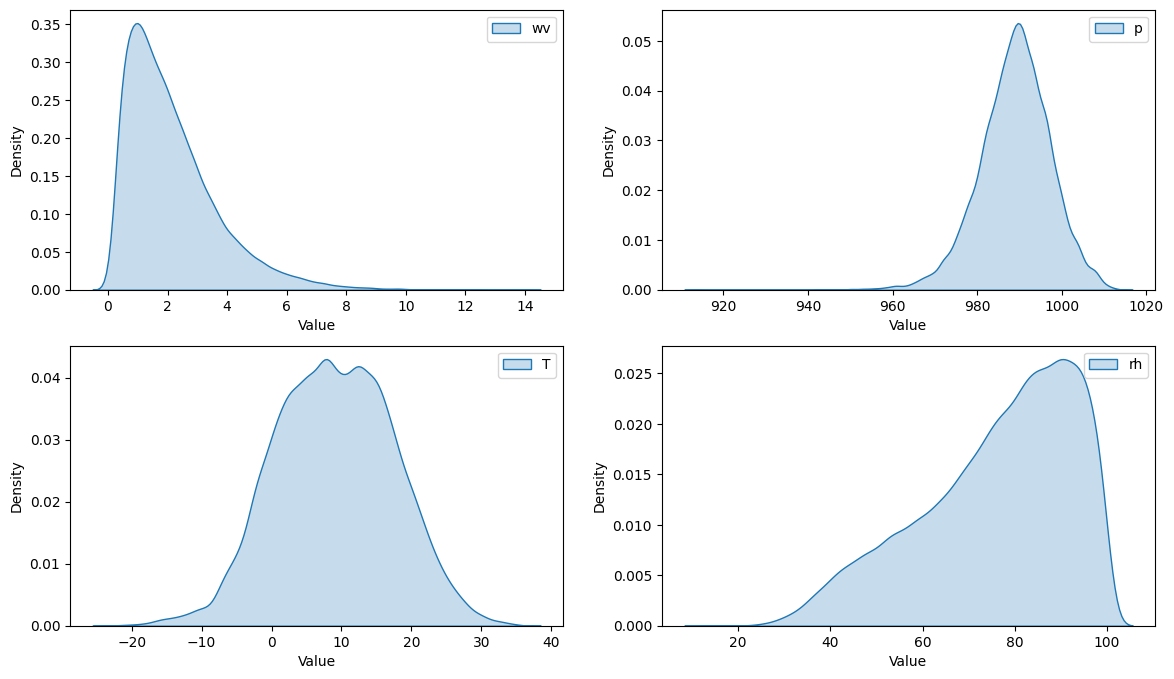

In [118]:
# Plot kernel density of all labels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(data['wv'], fill=True,  label='wv', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(data['p'], fill=True,  label='p', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(data['T'], fill=True,  label='T', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(data['rh'], fill=True,  label='rh', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

We observe that both "wind velocity" (wv) and "pressure" (p) labels have long tails , denoting the presence of outliers in the distribution of their values.

At first, we guessed hypothesized that removing those outliers might help the model generalize better, so we removed them, here is the resulting distribution of the labels.

In [119]:
data['date'] = data['date'].apply(lambda x: x.replace(minute=0))
data.drop("date", inplace=True, axis=1)

In [120]:
# Define the clipping range for outliers
clip_min = data.quantile(0.01)
clip_max = data.quantile(0.99)

# Scale the data with clipping for outliers
df_scaled = data.clip(clip_min, clip_max, axis=1)

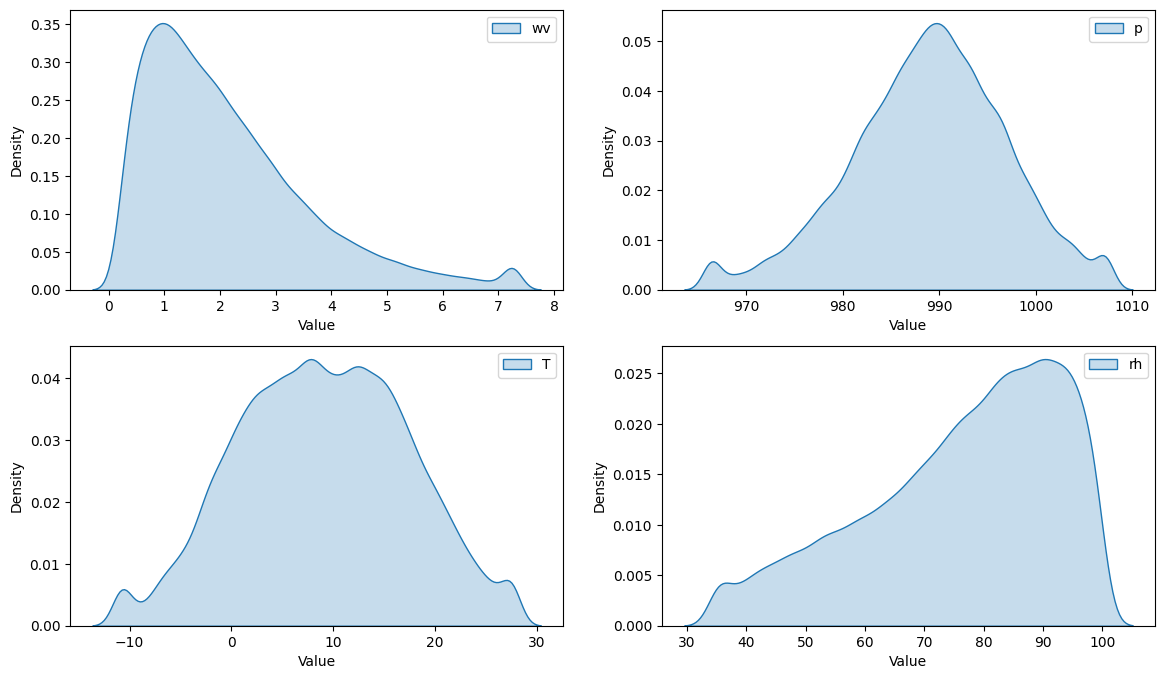

In [121]:
# Plot kernel density of all labels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(df_scaled['wv'], fill=True,  label='wv', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(df_scaled['p'], fill=True,  label='p', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(df_scaled['T'], fill=True,  label='T', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(df_scaled['rh'], fill=True,  label='rh', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

However, after running multiple experiments, we saw that clipping those values was actually reducing the performance of our model on the test set, so we did not pursue further with the clipped data.

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                56072 non-null  float64
 1   T                56072 non-null  float64
 2   Tpot (K)         56072 non-null  float64
 3   Tdew (degC)      56072 non-null  float64
 4   rh               56072 non-null  float64
 5   VPmax (mbar)     56072 non-null  float64
 6   VPact (mbar)     56072 non-null  float64
 7   VPdef (mbar)     56072 non-null  float64
 8   sh (g/kg)        56072 non-null  float64
 9   H2OC (mmol/mol)  56072 non-null  float64
 10  rho (g/m**3)     56072 non-null  float64
 11  wv               56072 non-null  float64
 12  max. wv (m/s)    56072 non-null  float64
 13  wd (deg)         56072 non-null  float64
dtypes: float64(14)
memory usage: 6.4 MB


In [123]:
data_df = data.copy()

Generally, models benefits a lot from having their input data scaled between two values. Here we chose to scale all the features and labels between -1 and 1.

In [124]:
# Scaling all the features between [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the DataFrame using MinMaxScaler, keep it so that we can re-use it on the test set
data_df[data_df.columns] = scaler.fit_transform(data_df)
data_df.head()

,p,T,Tpot (K),Tdew (degC),rh,VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv,max. wv (m/s),wd (deg)
0,0.652876,-0.496319,-0.506454,-0.330547,0.869949,-0.917727,-0.830175,-0.990905,-0.834852,-0.832438,0.487084,-0.970021,-0.946383,0.070556
1,0.655269,-0.524739,-0.534986,-0.371918,0.842081,-0.925048,-0.847668,-0.989947,-0.851936,-0.849624,0.513365,-0.964311,-0.946383,0.057222
2,0.659655,-0.522342,-0.533288,-0.367321,0.849048,-0.924699,-0.845481,-0.990426,-0.849658,-0.847476,0.512946,-0.974304,-0.946383,-0.071111
3,0.662646,-0.530560,-0.541780,-0.382365,0.828147,-0.926791,-0.851312,-0.988990,-0.855353,-0.853921,0.521506,-0.985724,-0.967660,0.333333
4,0.672017,-0.550419,-0.562840,-0.408692,0.818857,-0.931323,-0.861516,-0.988990,-0.865604,-0.863946,0.542938,-0.942898,-0.925106,-0.127778


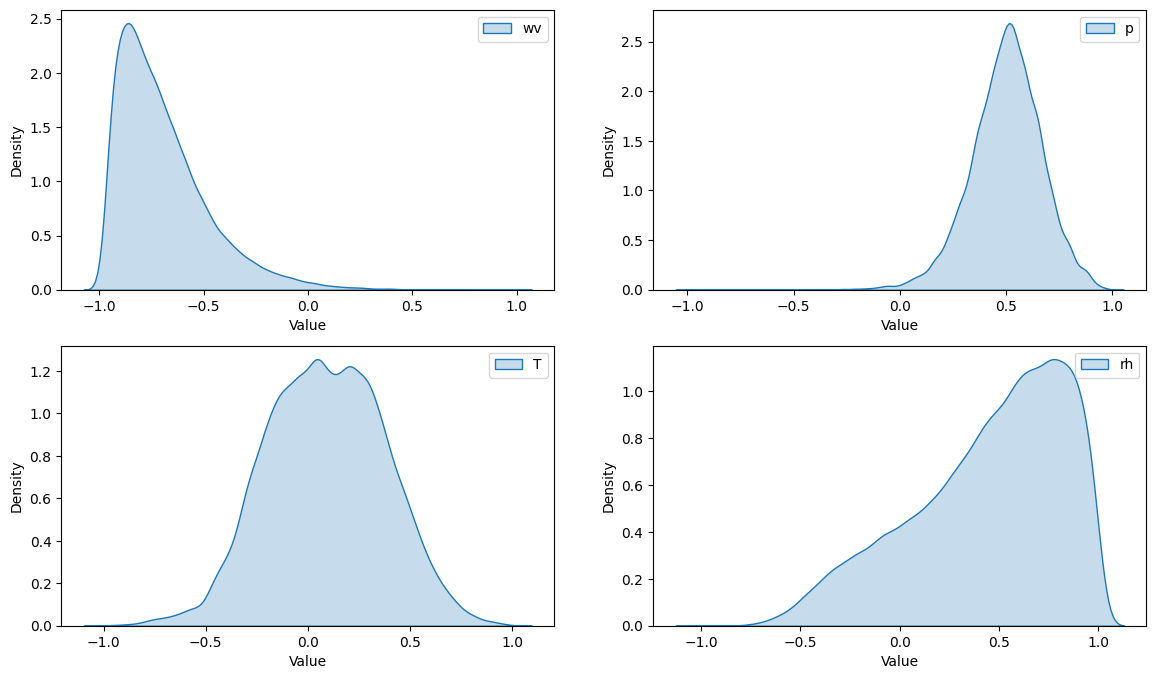

In [125]:
# Plot kernel density of all labels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(data_df['wv'], fill=True,  label='wv', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(data_df['p'], fill=True,  label='p', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(data_df['T'], fill=True,  label='T', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(data_df['rh'], fill=True,  label='rh', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

## Model architecture

The architecture is very simple as it derives from the transformer architecture. Thus, the overview of the architecture is the following :


1.   One linear embedding layer
2.   Positional embedding layer (not learned)
3.   One transformer encoder layer
4.   One linear decoding layer





In [126]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [127]:
class TimeFormer(nn.Module):
    def __init__(self,feature_size=250,num_encoder_layers=1,dropout=0.1, nbr_labels=4, nbr_features=4, enc_seq_len=4):
        super(TimeFormer, self).__init__()

        self.input_embedding  = nn.Linear(nbr_features, feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers, norm=None)
        self.decoder = nn.Linear(feature_size * enc_seq_len, nbr_labels)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != src.shape[1]:
            device = src.device
            mask = self._generate_square_subsequent_mask(src.shape[1]).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src) # positional embedding
        output = self.transformer_encoder(src,self.src_mask) # transformer encoder
        output = output.reshape(output.shape[0], -1) # flatten the output
        output = self.decoder(output)  # linear transformation decoder
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


We create the a dataset class to encapsulate and format our data :

In [128]:
class TimeFormerDataset(Dataset):
    """
    Dataset class used for TimeFormer model.
    """
    def __init__(self, data_df, enc_seq_len=4, window_step=1, labels_as_features=False, steps_ahead=0):
        super().__init__()

        self.labels = torch.from_numpy(data_df.loc[:, ["p", "T", "rh", "wv"]].to_numpy()).type(torch.float32)
        self.features = None
        if not labels_as_features:
            self.features = torch.from_numpy(data_df.loc[:, [k for k in data_df.columns if k not in ["p", "T", "rh", "wv", "date"]]].to_numpy()).type(torch.float32)

        # list of tuple (start, end) of the sequences according to window_step and enc_seq_len
        self.seq_list = [(i, i + enc_seq_len + steps_ahead) for i in range(0, len(data_df) - enc_seq_len - steps_ahead, window_step)]
    
    def __len__(self):
        return len(self.seq_list)
    
    def __getitem__(self, idx):
        """ 
        Returns the input and target sequences for a given index.
        """

        # get the start and end of the sequence
        start, end = self.seq_list[idx]

        # get the input sequence
        src_seq = torch.cat((self.features[start:end], self.labels[start:end]), dim=1) if self.features is not None else self.labels[start:end]
        trgt_seq = self.labels[end]

        return src_seq, trgt_seq.squeeze()

## Training

### Training and evaluation functions

In [129]:
# training function
def train(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader, device, save_path):
    
    train_losses = []
    val_losses = []
    lrs = []
    pbar = tqdm(range(epochs), desc="Epochs", leave=True, position=0)

    start = time.time()
    for i, epoch in enumerate(pbar):

        total_loss = 0.
        lrs.append(optimizer.param_groups[0]['lr'])
        model.train()
        for batch in train_loader:  
            
            srcs = batch[0].to(device)
            trgts = batch[1].to(device)

            optimizer.zero_grad()
            output = model(srcs)
            loss = criterion(output, trgts)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

            total_loss += loss.item()
        
        train_losses.append(total_loss / len(train_loader))

        # validation
        total_loss = 0.
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                srcs = batch[0].to(device)
                trgts = batch[1].to(device)

                output = model(srcs)
                loss = criterion(output, trgts)

                total_loss += loss.item()
            
            val_losses.append(total_loss / len(val_loader))
        
        # update scheduler
        #scheduler.step(val_losses[-1])
        if scheduler is not None:
          scheduler.step()

        pbar.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], lr=lrs[-1])
        
        # checkpoint
        if i % 10 == 0:
            torch.save(model.state_dict(), save_path)
    
    end = time.time()
    print(f"Training time: {end - start:.2f} seconds")
    
    return model, train_losses, val_losses, lrs

In [130]:
# evaluation function
def evaluate(model, criterion, test_loader, device, separate_labels=False, nbr_labels=4):
    model.eval()
    losses = [0] * nbr_labels
    with torch.no_grad():
        total_loss = 0.
        for batch in test_loader:
            srcs = batch[0].to(device)
            trgts = batch[1].to(device)

            output = model(srcs)
            if separate_labels:
              for i in range(output.shape[1]):
                losses[i] += criterion(output[:, i], trgts[:, i]).item()
            else:
              total_loss += criterion(output, trgts).item()
        
        return total_loss / len(test_loader) if not separate_labels else np.array(losses) / len(test_loader)

### Basic training

In [131]:
# hyperparameters
epochs = 25
lr = 1e-3
enc_seq_len = 4 # number of past observations to use
window_step = 1 # step between two consecutive windows
nbr_labels = 4 # number of labels to predict
batch_size = 32
dropout = 0.1
num_encoder_layers = 1 # number of transformer encoder layers
feature_size = 250 # size of the feature vector in the input embedding layer
labels_as_features = False
nbr_features = 4 if labels_as_features else 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [132]:
# datasets and dataloaders
time_ds = TimeFormerDataset(data_df, enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=labels_as_features)

train_size = int(0.9 * len(time_ds)) # 90% for training
val_size = len(time_ds) - train_size

train_ds, val_ds = random_split(time_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [133]:
# training 

model = TimeFormer(
    nbr_labels=nbr_labels, 
    nbr_features=nbr_features,
    enc_seq_len=enc_seq_len, 
    feature_size=feature_size, 
    num_encoder_layers=num_encoder_layers, 
    dropout=dropout).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=False)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model, train_losses, val_losses, lrs = train(model, criterion, optimizer, None, epochs, train_loader, val_loader, device, "timeformer.pth")

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]/home/rbazin/ECSE552/ECSE552-HW4/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
Epochs: 100%|██████████| 25/25 [02:26<00:00,  5.86s/it, lr=0.001, train_loss=0.00645, val_loss=0.00664]

Training time: 146.39 seconds


In [20]:
print("Saving final model")
torch.save(model.state_dict(), "timeformer_final.pth")

Saving final model


In [67]:
print(f"Final losses | Train loss: {train_losses[-1]:.4f} | Val loss: {val_losses[-1]:.4f}")

Final losses | Train loss: 0.0217 | Val loss: 0.0216


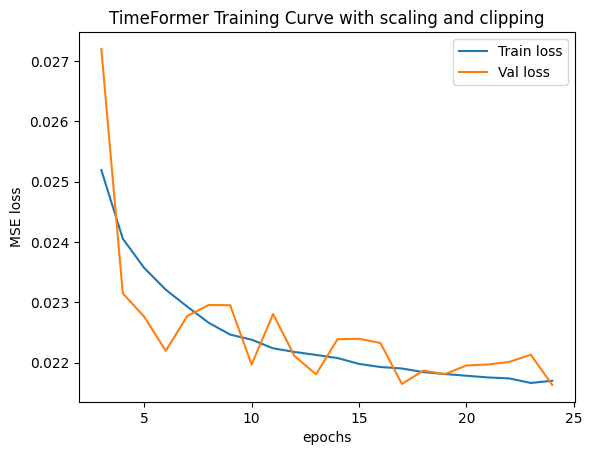

In [70]:
# plot losses
start_epoch = 3
plt.plot(list(range(start_epoch, len(train_losses))), train_losses[start_epoch:], label="Train loss")
plt.plot(list(range(start_epoch, len(train_losses))), val_losses[start_epoch:], label="Val loss")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("TimeFormer Training Curve with scaling")
plt.legend()

In [ ]:
# plot lr
plt.plot(lrs, label="learning rate")
plt.legend()

In [71]:
losses = evaluate(model, criterion, val_loader, device, separate_labels=True, nbr_labels=4)
print(losses)

[0.00320342 0.00312381 0.01785616 0.06234479]


The MSE (x10^4) per label is the following : 

|     |   p   |   T  |   rh  |   wv   |
|:---:|:-----:|:----:|:-----:|:------:|
| MSE | 1.144 | 8.31 | 87.56 | 167.54 |

We can see that the main source of error comes from the label "wind velocity" (wv).

### 10-fold cross-validation training

In [41]:
from sklearn.model_selection import KFold

In [42]:
# hyperparameters
epochs = 25
lr = 1e-3
enc_seq_len = 4 # number of past observations to use
window_step = 1 # step between two consecutive windows
nbr_labels = 4 # number of labels to predict
batch_size = 32
dropout = 0.1
num_encoder_layers = 1 # number of transformer encoder layers
feature_size = 250 # size of the feature vector in the input embedding layer
labels_as_features = False
nbr_features = 4 if labels_as_features else 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [43]:
num_folds = 10
kf = KFold(n_splits=num_folds)
time_ds = TimeFormerDataset(data_df, enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=labels_as_features)

folds_val_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(time_ds)):
    print(f"Training on Fold {fold + 1}")

    # initialize the model for this fold
    model = TimeFormer(
      nbr_labels=nbr_labels, 
      nbr_features=nbr_features,
      enc_seq_len=enc_seq_len, 
      feature_size=feature_size, 
      num_encoder_layers=num_encoder_layers, 
      dropout=dropout).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Split the dataset into train and val sets for this fold
    train_set = torch.utils.data.Subset(time_ds, train_index)
    val_set = torch.utils.data.Subset(time_ds, val_index)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    # Train the model for this fold
    model, train_losses, val_losses, lrs = train(model, criterion, optimizer, None, epochs, train_loader, val_loader, device, "timeformer.pth")
    val_losses = np.array(val_losses)
    folds_val_losses.append(val_losses.mean())
    print(f"Fold val loss : {val_losses.mean()}")

Training on Fold 1


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
Epochs: 100%|██████████| 25/25 [05:39<00:00, 13.58s/it, lr=0.001, train_loss=0.0064, val_loss=0.00673]


Training time: 339.50 seconds
Training on Fold 2


Epochs: 100%|██████████| 25/25 [05:15<00:00, 12.64s/it, lr=0.001, train_loss=0.00644, val_loss=0.00677]


Training time: 315.94 seconds
Training on Fold 3


Epochs: 100%|██████████| 25/25 [05:09<00:00, 12.37s/it, lr=0.001, train_loss=0.00649, val_loss=0.00634]


Training time: 309.19 seconds
Training on Fold 4


Epochs: 100%|██████████| 25/25 [05:10<00:00, 12.43s/it, lr=0.001, train_loss=0.00647, val_loss=0.00629]


Training time: 310.85 seconds
Training on Fold 5


Epochs: 100%|██████████| 25/25 [05:05<00:00, 12.21s/it, lr=0.001, train_loss=0.00642, val_loss=0.00669]


Training time: 305.22 seconds
Training on Fold 6


Epochs: 100%|██████████| 25/25 [05:04<00:00, 12.18s/it, lr=0.001, train_loss=0.00638, val_loss=0.0068]


Training time: 304.49 seconds
Training on Fold 7


Epochs: 100%|██████████| 25/25 [05:05<00:00, 12.24s/it, lr=0.001, train_loss=0.00654, val_loss=0.0061]


Training time: 306.00 seconds
Training on Fold 8


Epochs: 100%|██████████| 25/25 [05:04<00:00, 12.18s/it, lr=0.001, train_loss=0.00645, val_loss=0.00628]


Training time: 304.47 seconds
Training on Fold 9


Epochs: 100%|██████████| 25/25 [05:02<00:00, 12.10s/it, lr=0.001, train_loss=0.00642, val_loss=0.00622]


Training time: 302.44 seconds
Training on Fold 10


Epochs: 100%|██████████| 25/25 [05:07<00:00, 12.31s/it, lr=0.001, train_loss=0.0065, val_loss=0.00649]

Training time: 307.64 seconds


In [8]:
folds_val_losses = np.array([0.00673, 0.00677, 0.00634, 0.00629, 0.00669, 0.0068, 0.0061, 0.00628, 0.00622, 0.00649])
mean_val_losses = folds_val_losses.mean()
std_val_losses = folds_val_losses.std()
print(f"Mean val : {mean_val_losses:.5f}, std : {std_val_losses:.5f}")

Mean val : 0.00647, std : 0.00024


## Evaluation

### MSE on test set

In [72]:
test_df = pd.read_csv(os.path.join(path, "weather_test.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
test_df.head()

/tmp/ipykernel_1220524/649081062.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2015-05-24 19:00:00,990.00,17.93,291.93,9.23,56.73,20.58,11.68,8.91,7.37,11.79,1179.50,1.58,2.16,34.37
1,2015-05-24 20:00:00,989.86,16.92,290.93,9.52,61.65,19.31,11.90,7.40,7.51,12.03,1183.33,0.23,0.60,20.89
2,2015-05-24 21:00:00,990.11,15.82,289.80,9.71,66.97,18.00,12.06,5.95,7.61,12.18,1188.07,0.26,0.52,252.00
3,2015-05-24 22:00:00,990.01,15.02,289.01,9.50,69.53,17.10,11.89,5.21,7.50,12.01,1191.32,1.22,1.88,218.50
4,2015-05-24 23:00:00,989.89,14.14,288.14,9.42,73.20,16.15,11.83,4.33,7.46,11.95,1194.85,1.43,1.96,218.00


In [73]:
test_df.sort_values(by='Date Time', ascending=True, inplace=True)

In [74]:
test_df = test_df.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

In [75]:
test_df['date'] = test_df['date'].apply(lambda x: x.replace(minute=0))

In [76]:
test_df.drop('date', inplace=True, axis=1)

In [77]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 0 to 14018
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                14019 non-null  float64
 1   T                14019 non-null  float64
 2   Tpot (K)         14019 non-null  float64
 3   Tdew (degC)      14019 non-null  float64
 4   rh               14019 non-null  float64
 5   VPmax (mbar)     14019 non-null  float64
 6   VPact (mbar)     14019 non-null  float64
 7   VPdef (mbar)     14019 non-null  float64
 8   sh (g/kg)        14019 non-null  float64
 9   H2OC (mmol/mol)  14019 non-null  float64
 10  rho (g/m**3)     14019 non-null  float64
 11  wv               14019 non-null  float64
 12  max. wv (m/s)    14019 non-null  float64
 13  wd (deg)         14019 non-null  float64
dtypes: float64(14)
memory usage: 1.6 MB


In [78]:
test_df[test_df.columns] = scaler.transform(test_df)

In [79]:
test_ds = TimeFormerDataset(test_df, enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=labels_as_features)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [80]:
test_losses = evaluate(model, criterion, test_loader, device, separate_labels=True, nbr_labels=4)
print(test_losses)

/home/rbazin/ECSE552/ECSE552-HW4/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


[6.38977720e-04 2.26771428e-03 1.30495289e-02 1.71851010e+03]


In [81]:
np.array(test_losses).mean()

429.63151471382446

The MSE (x10^4) computed on the test set is the following :

|     |   p   |   T  |   rh  |   wv   | average |
|:---:|:-----:|:----:|:-----:|:------:|:-------:|
| MSE | 3.90 | 8.36 | 80.13 | 4.34e6 | 1.08e6 |

We can see that for the labels p (pressure), T (temperature) and rh (relative humidity), the MSE computed on the test set is very close to the one computed on the validation set, and is globally very low. However, the model fails completely to predict the correct values of wv (wind velocity).

This can come from a wide variety of reasons, such as :

*   the training distribution wasn't representative of the true (or just testing) distribution.
*   the training distribution was representative but the distribution is too complex for the model to understand it.
* the window of observations from the past is too short for the model to understand the pattern of this label.



### Error propagation

In [84]:
def evaluate_error_propagation(model, criterion, test_loader, device, enc_seq_len=enc_seq_len, nbr_labels=4, steps_ahead=0, separate_labels=False):
    model.eval()
    losses = [0] * nbr_labels
    with torch.no_grad():
        total_loss = 0.
        for batch in test_loader:
            srcs = batch[0].to(device)
            trgts = batch[1].to(device)

            output = model(srcs[:, :enc_seq_len, :])

            # TODO : adapt for multi steps 
            for i in range(1, steps_ahead):
              src = srcs[:, i:enc_seq_len + i, :]
              src[:, -1, -nbr_labels:] = output
              output = model(src)

            if separate_labels:
              for i in range(output.shape[1]):
                losses[i] += criterion(output[:, i], trgts[:, i]).item()
            else:
              total_loss += criterion(output, trgts).item()
        
        return total_loss / len(test_loader) if not separate_labels else np.array(losses) / len(test_loader)

In [ ]:
losses_steps_ahead = []
for steps_ahead in range(1, 11):
    error_prop_ds = test_ds = TimeFormerDataset(test_df, steps_ahead=steps_ahead ,enc_seq_len=enc_seq_len, window_step=window_step, labels_as_features=labels_as_features)
    error_prop_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    losses = evaluate_error_propagation(model, criterion, error_prop_loader, device, steps_ahead = steps_ahead, enc_seq_len = enc_seq_len, nbr_labels = nbr_labels, separate_labels = True)
    losses_steps_ahead.append(losses)

In [86]:
losses_steps_ahead = np.array(losses_steps_ahead)
print(losses_steps_ahead.shape)

(10, 4)


In [90]:
print(losses_steps_ahead[:, -1])

[1720.70913618 1721.72912234 1721.71079488 1721.74671572 1721.76704974
 1721.76222042 1721.76017635 1721.75325337 1721.74309899 1721.7381392 ]


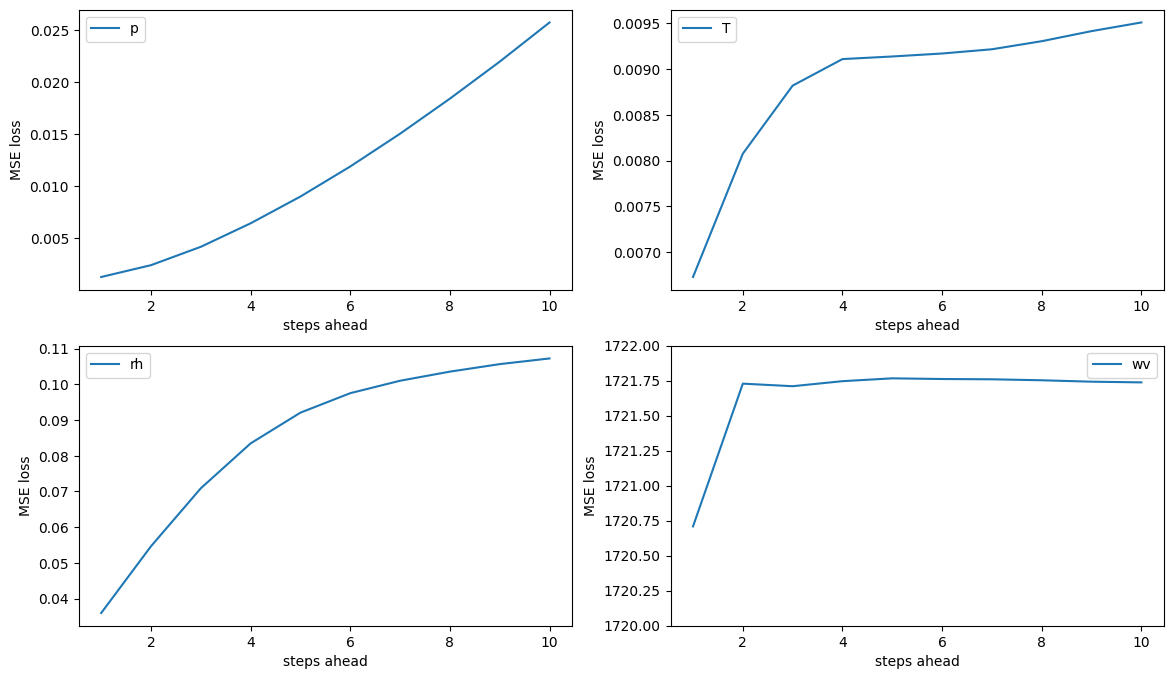

In [91]:
# plot means and stds 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
ax = ax.flatten()
ax[0].plot(list(range(1, 11)), losses_steps_ahead[:, 0], label="p")
ax[0].set_xlabel("steps ahead")
ax[0].set_ylabel("MSE loss")
ax[0].legend()
ax[1].plot(list(range(1, 11)), losses_steps_ahead[:, 1], label="T")
ax[1].set_xlabel("steps ahead")
ax[1].set_ylabel("MSE loss")
ax[1].legend()
ax[2].plot(list(range(1, 11)), losses_steps_ahead[:, 2], label="rh")
ax[2].set_xlabel("steps ahead")
ax[2].set_ylabel("MSE loss")
ax[2].legend()
ax[3].plot(list(range(1, 11)), losses_steps_ahead[:, 3], label="wv")
ax[3].set_ylim(1720, 1722)
ax[3].set_xlabel("steps ahead")
ax[3].set_ylabel("MSE loss")
ax[3].legend()

#fig.suptitle('Error propagation for different steps ahead') 